In [16]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 20,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.TTree
mcsangle:pl.DataFrame
dfana:pl.DataFrame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
anatree = Anatree(f'', load_data=False)
anatree.tree:uproot.TTree

In [631]:
nu: pl.DataFrame
reco_tracks:pl.DataFrame
nu_new:pl.DataFrame
reco_tracks_new:pl.DataFrame
def get_df(filename):
    anatree = Anatree(f'', load_data=False)
    anatree.tree:uproot.TTree
    anatree.read_parquet(filename)
    def select_numu_cc(df:pl.DataFrame):
        df = df.with_columns(
            E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
            Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>-1).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
            Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>-1).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
        ).filter(
            pl.col('LongestTrackContNumu')==0
        )
        return df
    df = select_numu_cc(anatree.nu.collect())

    return df

dfnu = get_df("../data/parquet_anatree_muon_only_chi2_llhd_change_chi2/")
dfnuvalid = get_df("../data/parquet_anatree_muon_only_chi2_llhd_change_chi2_valid/")
dfnuvalidsoft = get_df("../data/parquet_anatree_muon_only_chi2_llhd_change_chi2_valid_soft/")


Reading nu files... 15/15

Reading reco_tracks files... 15/15

Reading pfp files... 15/15
Reading nu files... 15/15

Reading reco_tracks files... 15/15

Reading pfp files... 15/15
Reading nu files... 15/15

Reading reco_tracks files... 15/15

Reading pfp files... 15/15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


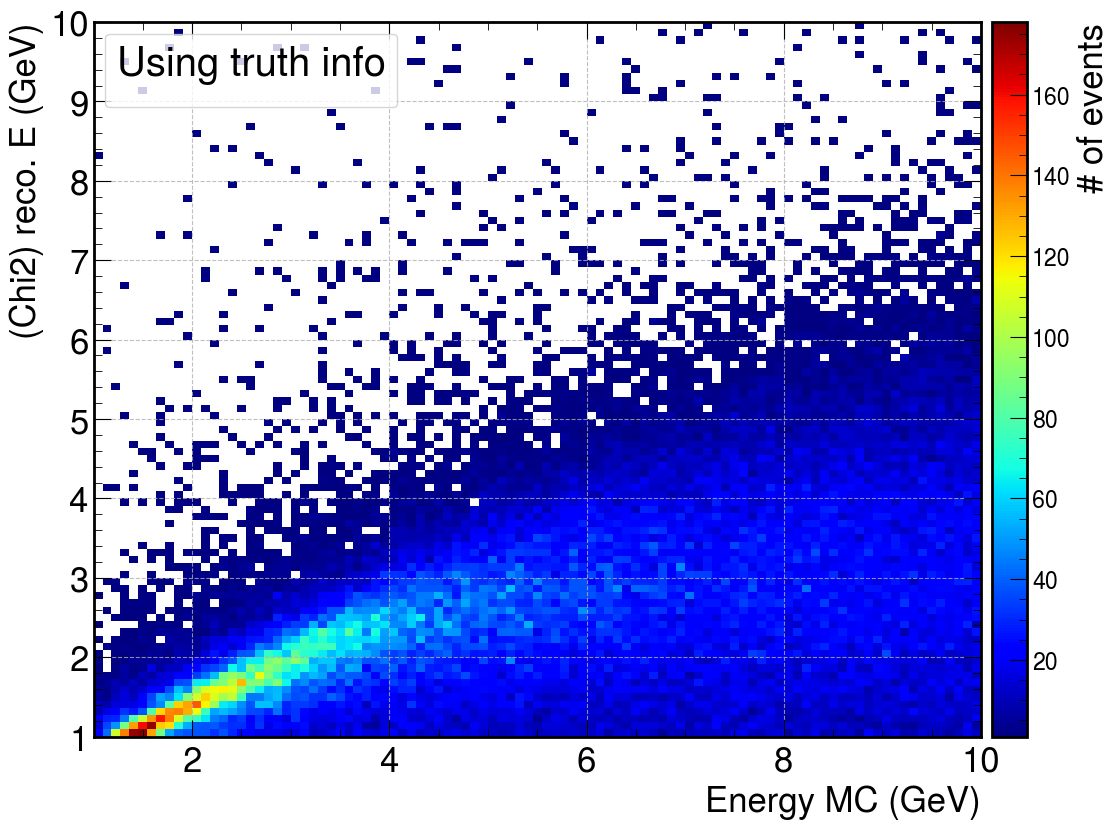

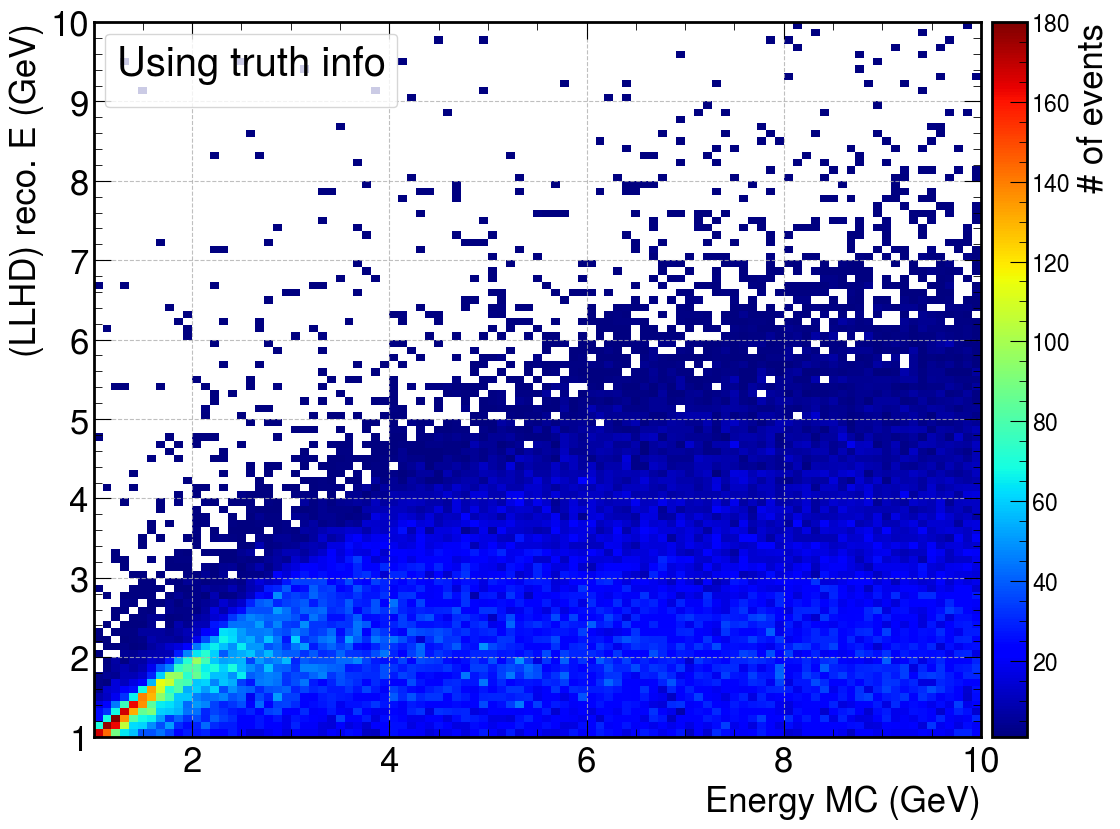

In [647]:
def plot_mu_vs_mu(Emu:pl.DataFrame, label, lmethod, x='E', y='RecoLepEnNumu'):

    fig = plt.figure(figsize=(12,8.7))
    binsx = np.linspace(1,10,100)
    binsy = np.linspace(1,10,100)
    fontsize=25
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm='linear', cmin=1,  cmap='jet');
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Energy MC (GeV)', fontsize=fontsize)
    plt.ylabel(f'{label} reco. E (GeV)', fontsize=fontsize)

    # plt.yscale('log')
    # plt.xscale('log')
    plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
    plt.setp(legend.get_title(),fontsize='x-large')

# plot_mu_vs_mu(Emu.filter(pl.col('rec.LongestTrackContNumu')==1), label='(old)')
plot_mu_vs_mu(dfnu,  y='Echi2', label='(Chi2)', lmethod='Using truth info')
plot_mu_vs_mu(dfnu,  y='Ellhd', label='(LLHD)', lmethod='Using truth info')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


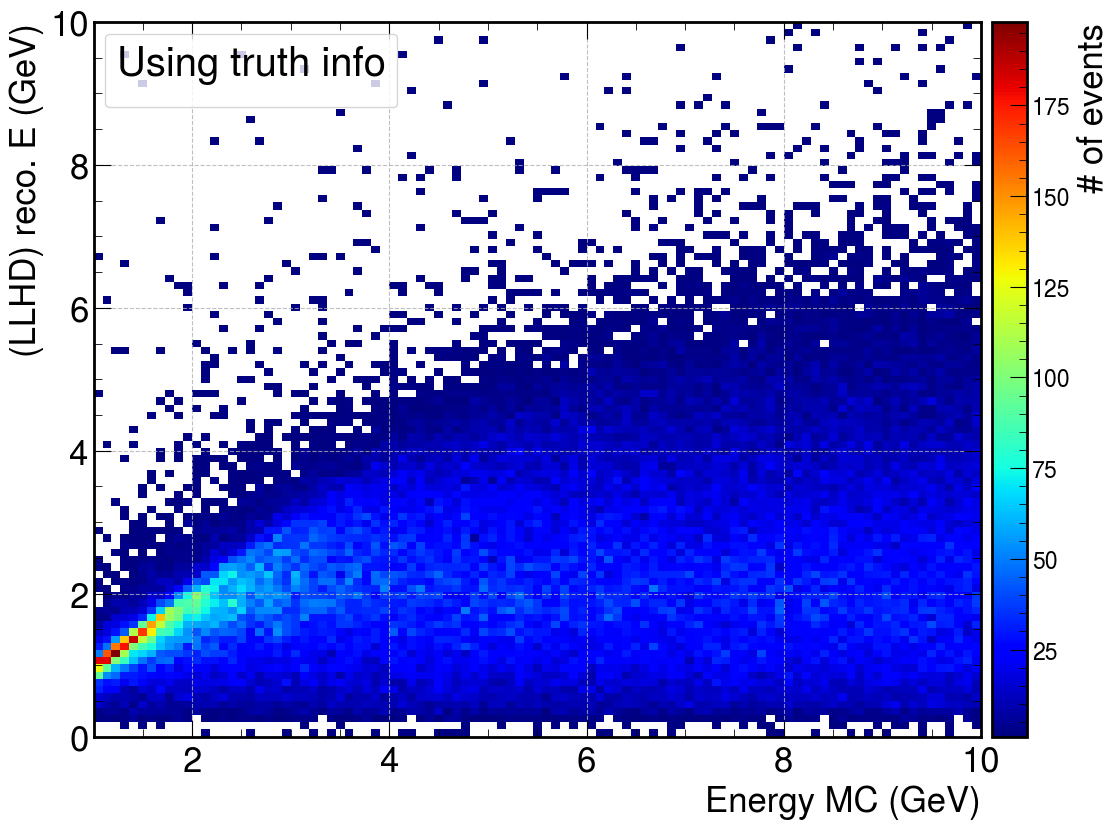

In [633]:
# plot_mu_vs_mu(dfnuvalid,  y='Echi2', label='(Chi2)', lmethod='Using truth info')
plot_mu_vs_mu(dfnuvalid,  y='Ellhd', label='(LLHD)', lmethod='Using truth info')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


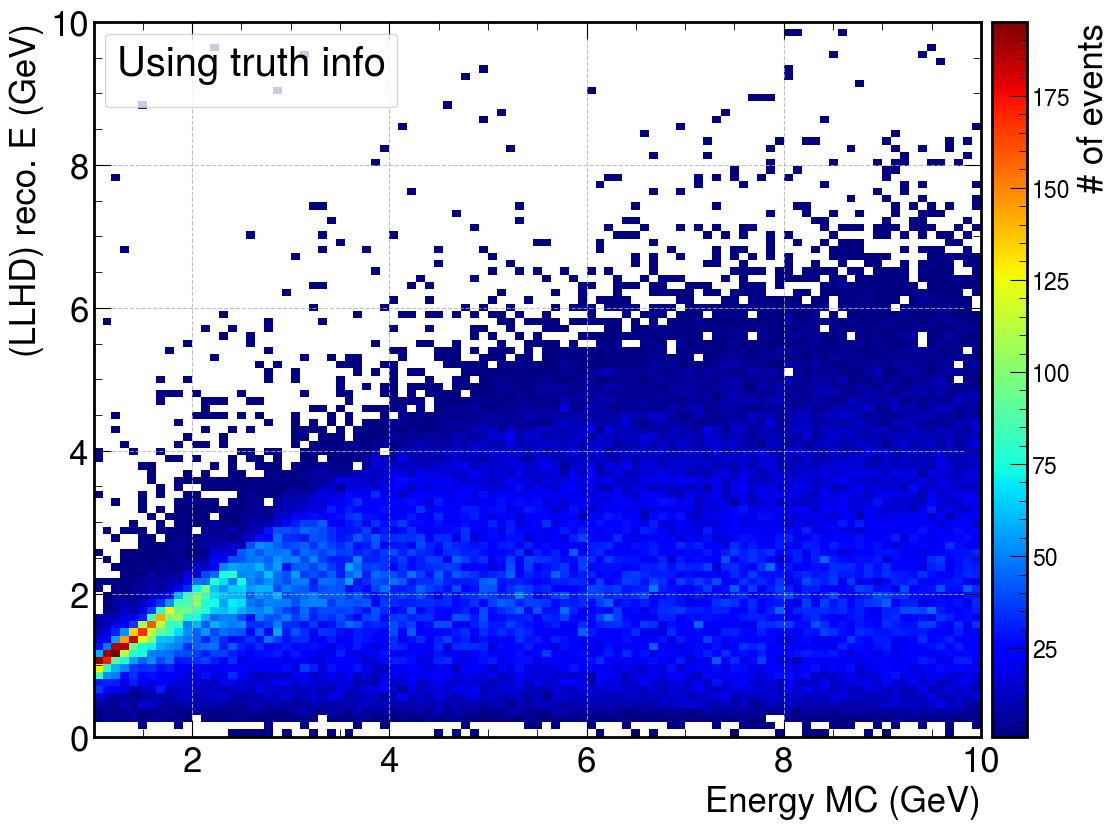

In [634]:
# plot_mu_vs_mu(dfnuvalidsoft,  y='Echi2', label='(Chi2)', lmethod='Using truth info')
plot_mu_vs_mu(dfnuvalidsoft,  y='Ellhd', label='(LLHD)', lmethod='Using truth info')

In [635]:
from scipy.stats import binned_statistic
from numba_stats import norm
from iminuit import cost, Minuit

def pdf(x, a, mu, sigma):
    return a*np.exp(- 0.5*(( x - mu )/(sigma))**2)

binsres = np.linspace(-1,2,100)

mtest = []
def gaus_fit(data:np.ndarray, return_error=True) -> float:
    global binsres
    h, hedges = np.histogram(data, bins=binsres)
    hcenters = (hedges[1:] + hedges[:-1])*0.5
    hcenters=hcenters[h>0]
    h=h[h>0]
    if len(h)<=1: return 0
    errh = [1./np.sqrt(x) for x in h]
    c = cost.LeastSquares(hcenters, h, errh, pdf)
    m = Minuit(c, a=np.max(h)/2, mu=0.1, sigma=0.2)
    m.limits["a"] = (0.1, 1e3)
    # m.fixed["a"]=True
    m.limits["mu"] = (-1, 2)
    m.limits["sigma"] = (0, None)
    m.migrad()
    mtest.append(m)
    return m.values["sigma"]
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'True Muon Momentum [GeV/c]',
                    ylabel = '',
                    makefrac = True,
                    fmt='+',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    **kwargs):
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Muon candidate resolution [%]'
        if title=='':
            title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$p_{reco}/p_{true}-1$'
        if title=='':
            title = 'Median'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, fontsize='large', title_fontsize='large')
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)

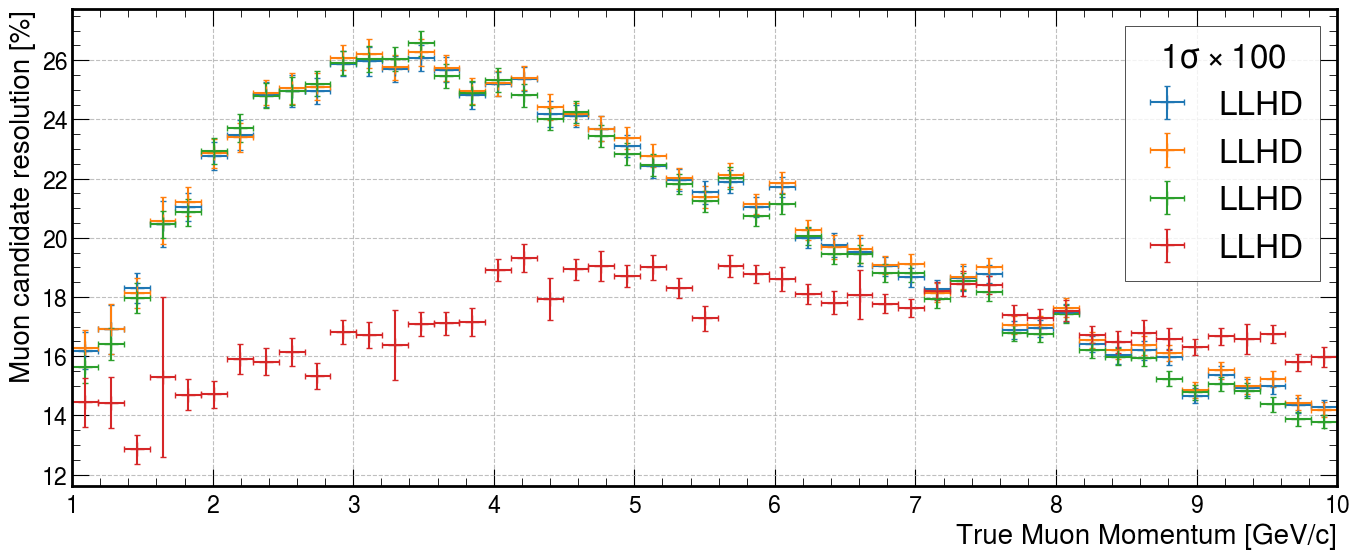

In [678]:
binsx= np.linspace(1,10,50)
xscale='linear'
binsx=binsx
capsize=2
label='LLHD'
plot_res_scatter(
    dfnu['E'],
    dfnu['Ellhd'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)
plot_res_scatter(
    dfnuvalid['E'],
    dfnuvalid['Ellhd'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)
plot_res_scatter(
    dfnuvalidsoft['E'],
    dfnuvalidsoft['Ellhd'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)
plot_res_scatter(
    dfnu['E'],
    dfnu['Echi2'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)

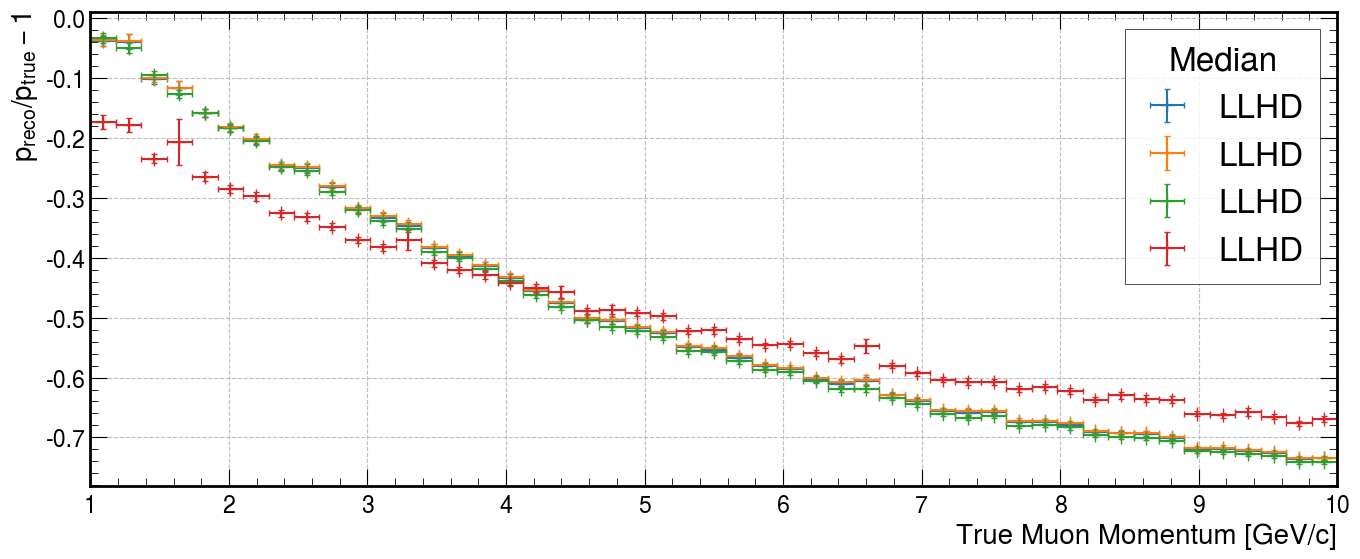

In [680]:
plot_res_scatter(
    dfnu['E'],
    dfnu['Ellhd'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)
plot_res_scatter(
    dfnuvalid['E'],
    dfnuvalid['Ellhd'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)
plot_res_scatter(
    dfnuvalidsoft['E'],
    dfnuvalidsoft['Ellhd'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)
plot_res_scatter(
    dfnu['E'],
    dfnu['Echi2'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)

In [ ]:
# idx=1
# # plt.hist(test[idx],bins=binsres, histtype='step');
# # plt.hist(plottest[idx][1][:-1], plottest[idx][1], weights=plottest[idx][0]);
# # plt.plot(binsres, pdf(binsres, atest[idx],mutest[idx], stest[idx]), 'o')
# mtest[idx].visualize();
# mtest[idx]